## Introduction Stan via P Growth Example

The model we will solve is

$$ \frac{dP}{dt} = \gamma P - \lambda P^2 $$

First we will load the required packages.

In [2]:
library(deSolve)
library(rstan)
options(mc.cores = parallel::detectCores())

We set our parameters, initial conditions, and simulation parameters

In [3]:
theta <- list(gamma =0.25, lambda=0.1)
x <- c(P=1)
T  <- 30
dt <- 1
nt <- T/dt
t  <- seq(0,T,length.out=nt)

We define the model in terms of a function that takes the time point, current, state, and parameters, and returns the value of the derivative.

In [4]:
dxdt <- function(t,x,theta){
    with(as.list(c(x,theta)),{
        dP <- gamma*P - lambda*P*P
        list(c(dP)) })}

Solve the ODE using the packaged ode solver.

In [5]:
x <- as.data.frame(ode(y=x, times=t, func=dxdt, parms=theta))

Plot the results

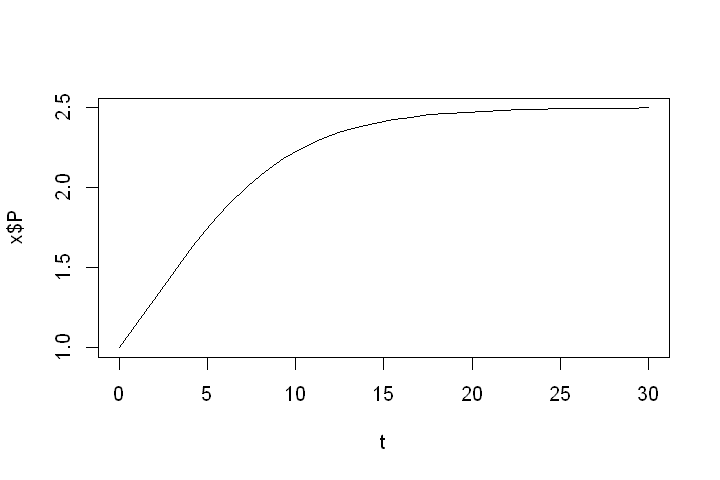

In [6]:
options(repr.plot.width=6, repr.plot.height=4)
plot(t,x$P,type='l')

We choose a few time points where we have observations, sample the simulation at those time points, and add a bit of error to the state variable.

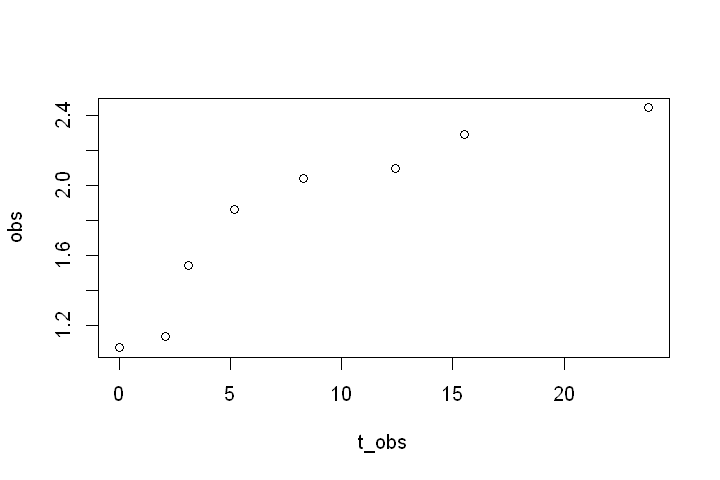

In [7]:
t_obs_ind <- c(1,3,4,6,9,13,16,24)
obs       <- x$P[t_obs_ind] + rnorm(length(t_obs_ind),sd=0.1)
t_obs     <- x$t[t_obs_ind] 
plot(t_obs,obs)

The Stan code below introduces the ODE solver functionality within Stan via two new blocks. 

#### `functions` block
This is where we define the function that returns the model derivatives as a function of the time step `t`, current state `x`, and parameters `theta`.
The Stan ODE solver also expects two additional objects, `x_r` and `x_i`, where you can supply boundary conditions and other inputs. 
We will not have to use these in our case studies and so will leave them empty.

#### `transformed parameters` block
Here is where we define the model state `x` which we treat as a transformed parameter in Stan.
We use the standard (non-stiff) version of the ODE solver within Stan which implements a fourth order Runge Kutta method.
The arguements of `integrate_ode_rk45` are 

`integrate_ode_rk45(<function>,<initial conditions>,<initialization code>,<time>,<x_r>,<x_i>,<rel_tol>,<abs_tol>,<num_steps>)`

Below we specify the initial conditions as a parameter and pass those parameters to the ODE solver. 
We pass the time argument the points where we want to obtain the posterior estimates. 
In general this set of time points will contain the time points where we have observations, in order for Stan to be able to compare the model prediction to the observation in the likelihood.
However, we could also ask Stan to evaluate the posterior at places where we don't have data which would give us the posterior predictive distribution at that point.
We we just need to pass Stan additional time indices in the `data` block to specify which times are being used in the likelihood.

Note that we can also use the ODE solver in the same way within the model block.
It is just personal preference.

More detailed descriptions of the ODE solver options is available [here](https://mc-stan.org/docs/2_21/functions-reference/functions-ode-solver.html)

In [8]:
stancode <- "functions {
   real[] P_growth(real t,       // time
                   real[] x,      // state
                   real[] theta, // parameters
                   real[] x_r,   // environmental data
                   int[] x_i){
    real gamma  = theta[1];
    real lambda = theta[2];

    real growth = gamma*x[1];
    real loss   = lambda*x[1]*x[1];
    
    return {growth - loss};
  }
}
data {
    int<lower = 0> N;           // num obs
    real t_obs[N];              // obs times
    real<lower = 0> y[N];       // observed variable at measurement times
    real sigma;
}
parameters {
    real<lower=0,upper=1> theta[2];      // parameters
    real<lower=0> x0[1];
}
transformed parameters {
    real x[N,1] = integrate_ode_rk45(P_growth, x0, -1, t_obs, theta,
                                      rep_array(0.0, 0), rep_array(0, 0),
                                      1e-6, 1e-5, 1e3);
}
model {
    //theta[1] ~ normal(0.1, 2);
    //theta[2] ~ normal(0.1, 2);
    x0       ~ normal(1.0, 10);
    y[1:N]   ~ normal(x[1:N,1], sigma); // obs
}"


Compile the model

In [9]:
mod <- stan_model(model_code=stancode)

Organize the data for Stan. 
Note that we are now passing the error standard deviation to Stan, instead of estimating it, and so appears in the `data` block and not the `parameter` block. 

In [10]:
data <- list(N=length(t_obs),
             t_obs=t_obs,
             y=obs,
             sigma=0.1)

Perform sampling

In [11]:
mcmc <- sampling(mod,data=data,iter=2000,chains=4,open_progress=TRUE)

Look at the mcmc summaries.

In [12]:
mcmc

Inference for Stan model: c6d12bf601e0452d638def398bcc2af2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd   2.5%    25%   50%   75% 97.5% n_eff Rhat
theta[1]  0.27    0.00 0.05   0.18   0.23  0.27  0.30  0.39   845 1.00
theta[2]  0.12    0.00 0.03   0.07   0.10  0.11  0.13  0.17   855 1.00
x0[1]     0.86    0.00 0.10   0.66   0.79  0.86  0.93  1.04   875 1.01
x[1,1]    1.01    0.00 0.08   0.84   0.95  1.01  1.06  1.16   957 1.01
x[2,1]    1.33    0.00 0.05   1.22   1.29  1.33  1.37  1.44  1856 1.00
x[3,1]    1.48    0.00 0.05   1.38   1.45  1.48  1.52  1.60  2189 1.00
x[4,1]    1.76    0.00 0.06   1.64   1.71  1.75  1.80  1.88  1457 1.00
x[5,1]    2.04    0.00 0.06   1.92   1.99  2.04  2.08  2.16  1418 1.00
x[6,1]    2.22    0.00 0.05   2.12   2.19  2.23  2.26  2.32  3227 1.00
x[7,1]    2.29    0.00 0.06   2.17   2.25  2.29  2.33  2.40  2814 1.00
x[8,1]    2.34    0.00 0.08   2.19   2.28

Extract mcmc samples

In [13]:
post <- extract(mcmc)

In [14]:
names(post)

[1] "theta" "x0"    "x"     "lp__"

Notice the dimensions of the variables.
mcmc samples are always the first dimension.

In [15]:
dim(post$theta)
dim(post$x0)
dim(post$x)

[1] 4000    2

[1] 4000    1

[1] 4000    8    1

Plot the posterior marginal distributions via histograms.

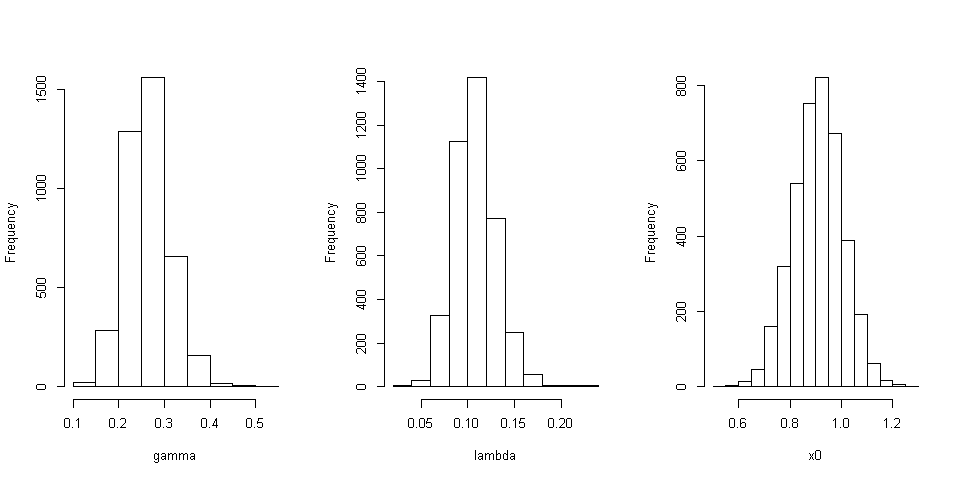

In [20]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
hist(post$theta[,1],xlab='gamma',main='')
hist(post$theta[,2],xlab='lambda',main='')
hist(post$x0,xlab='x0',main='')

Plot the joint distribution.

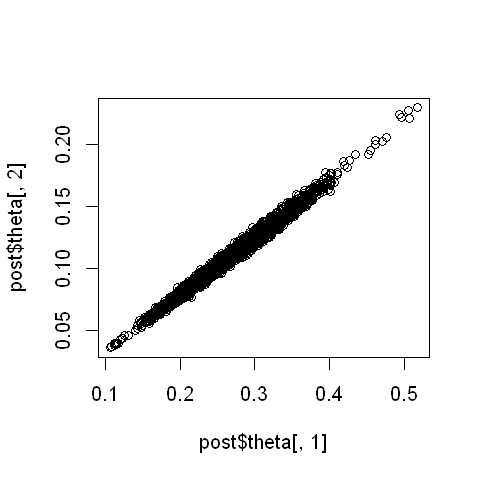

In [22]:
options(repr.plot.width=4, repr.plot.height=4)
plot(post$theta[,1],post$theta[,2])

## Periodic P Growth
We will extend the model to include sinusoidal growth

$$ \frac{dP}{dt} = \gamma\left(1+\sin (\omega t)\right) P - \lambda P^2  $$

Specify parameters for synthetic data.

In [24]:
theta_sin <- list(gamma =0.25,
                  lambda=0.1,
                  period=365,
                  omega =2*pi/365,
                      dt=1)
x_sin <- c(P   =2.5,
           time=0)
T_sin  <- 365*4
dt_sin <- 1
nt_sin <- T_sin/dt_sin

t_sin  <- seq(0,T_sin,length.out=nt_sin)

Definte function to simulate data

In [25]:
dxdt_sin <- function(t,x,theta){
    with(as.list(c(x,theta)),{
        dP      <- gamma*(1+sin(omega*time))*P - lambda*P*P
        delta_t <- dt
        list(c(dP, delta_t))
    })
}

Solve ODE using ODE package

In [26]:
x_sin <- as.data.frame(ode(y=x_sin, times=t_sin, func=dxdt_sin, parms=theta_sin))

Plot solution

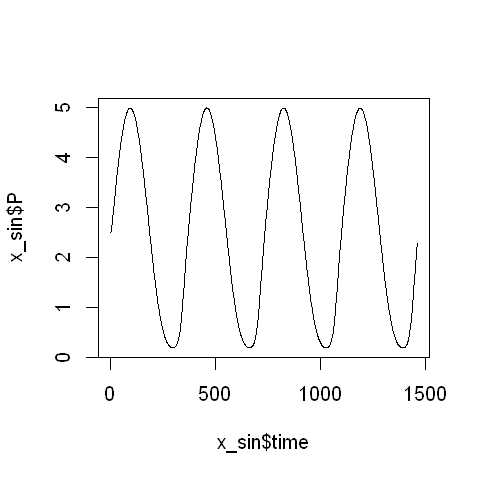

In [27]:
plot(x_sin$time,x_sin$P,type='l')

Choose random time points to sample the solution.
Make sure the observations aren't negative after adding random observational noise.

In [28]:
t_obs_ind_sin      <- sort(sample(1:length(t_sin),50))
obs_sin            <- x_sin$P[t_obs_ind_sin] + rnorm(length(t_obs_ind_sin),sd=0.5)
obs_sin[obs_sin<0] <- 0
t_obs_sin          <- x_sin$time[t_obs_ind_sin] 

Plot the synthetic observations.

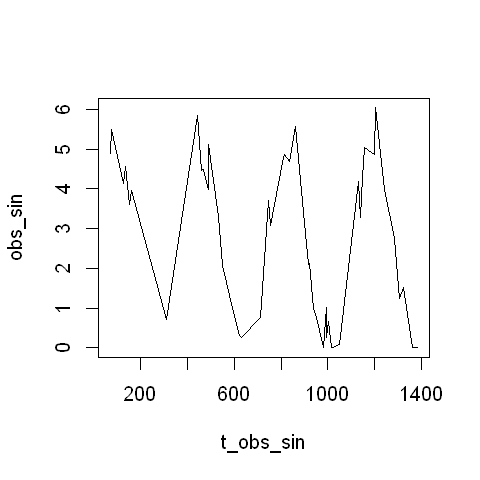

In [29]:
plot(t_obs_sin,obs_sin,type='l')

The Stan code below implements the modified model. 
Notice the `growth` calculation where we calculate the sinusoidal component via the model variable `t`. 

In [30]:
stancode_sin <- "functions {
   real[] P_growth(real t,       // time
                   real[] x,      // state
                   real[] theta, // parameters
                   real[] x_r,   // environmental data
                   int[] x_i){
    real gamma  = theta[1];
    real lambda = theta[2];
	//real a      = theta[3];

    real growth = gamma*x[1] + gamma*sin(2*pi()*(1.0/365.0)*t)*x[1];
    real loss   = lambda*x[1]*x[1];
    
    return {growth - loss};
  }
}
data {
    int<lower = 0> N;           // num obs
    real<lower = 0> t_obs[N];              // obs times
    real<lower = 0> y[N];       // observed variable at measurement times
    //real<lower = 0> sigma;
}
parameters {
    real<lower=0> theta[2];      // parameters
    real<lower=0> x0[1];
	real<lower=1E-15> sigma;
}
transformed parameters {
    real<lower=0> x[N,1] = integrate_ode_rk45(P_growth, x0, 1, t_obs, theta,
                                      rep_array(0.0, 0), rep_array(0, 0),
                                      1e-6, 1e-6, 1e5);
}
model {
    theta[1] ~ normal(0.1, 1);
    theta[2] ~ normal(0.1, 1);
	//theta[3] ~ normal(0.01,1);
    x0       ~ normal(1.0, 10);
    y[1:N]   ~ normal(x[1:N,1], sigma); // obs
}"


Compile the Stan code.

In [31]:
mod_sin <- stan_model(model_code=stancode_sin)

Organize the data

In [32]:
data_sin <- list(N=length(t_obs_sin),
             t_obs=round(t_obs_sin),
             y=obs_sin)

Perform mcmc sampling

In [33]:
mcmc_sin <- sampling(mod_sin,data=data_sin,iter=2000,chains=4,open_progress=TRUE)

Look at the summaries of the mcmc chains

In [34]:
mcmc_sin

Inference for Stan model: 88abac259638d91ada7fb287ff6180c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd 2.5%   25%   50%   75% 97.5% n_eff Rhat
theta[1]  0.83    0.02 0.53 0.21  0.42  0.69  1.11  2.14   980    1
theta[2]  0.33    0.01 0.21 0.08  0.17  0.27  0.44  0.85   980    1
x0[1]     8.55    0.15 6.11 0.42  3.83  7.37 12.06 23.07  1557    1
sigma     0.48    0.00 0.05 0.40  0.45  0.48  0.51  0.59  1867    1
x[1,1]    4.87    0.00 0.10 4.67  4.81  4.87  4.94  5.06  3638    1
x[2,1]    4.93    0.00 0.10 4.73  4.86  4.93  4.99  5.12  3681    1
x[3,1]    4.62    0.00 0.09 4.44  4.56  4.62  4.68  4.80  3630    1
x[4,1]    4.44    0.00 0.09 4.26  4.38  4.44  4.50  4.62  3541    1
x[5,1]    3.79    0.00 0.08 3.63  3.73  3.79  3.84  3.94  3082    1
x[6,1]    3.48    0.00 0.08 3.33  3.43  3.48  3.53  3.63  2809    1
x[7,1]    0.20    0.00 0.04 0.17  0.18  0.19  0.22  0.30  1445    1
x[8,1]

Extract posterior samples

In [35]:
post_sin <- extract(mcmc_sin)

Plot the histograms

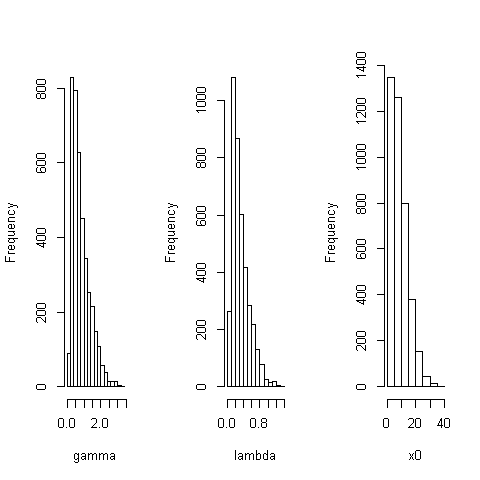

In [36]:
par(mfrow=c(1,3))
hist(post_sin$theta[,1],xlab='gamma',main='')
hist(post_sin$theta[,2],xlab='lambda',main='')
hist(post_sin$x0,xlab='x0',main='')

Plot the joint distribution

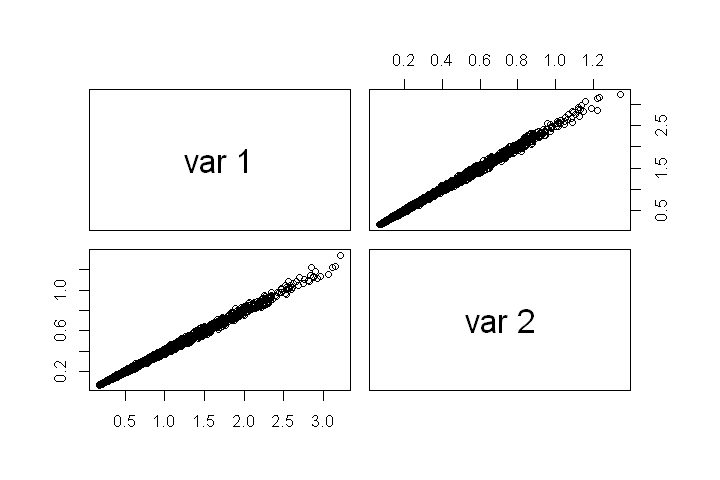

In [42]:
pairs(post_sin$theta)

Calculate the mean and standard deviation of the fitted `x`s and plot them.

In [43]:
mu  <- colMeans(post_sin$x[,,1])
std <- apply(post_sin$x[,,1],2,sd) 

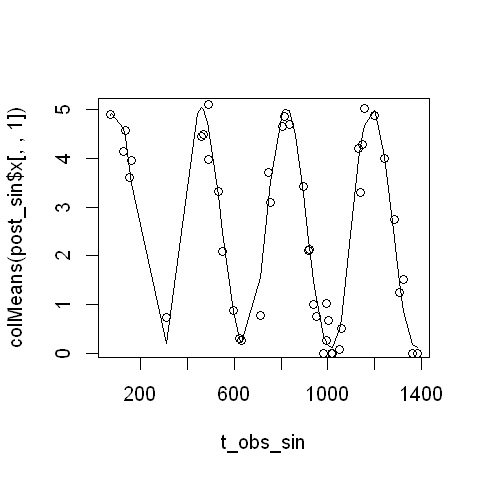

In [44]:
plot(t_obs_sin,colMeans(post_sin$x[,,1]),type='l')
points(t_obs_sin,obs_sin)